# Overview

The purpose of this notebook is to automate the automatic FRC calculation for in-sample/out-of-sample neural net predictions for PtychoPINN.

We provide a list of directories containing the data associated with each experiment. We also provide a complete list of models we want to test, which will be a dictionary containing the *model names/descriptions* as **values** with the *MLFlow uri* as **keys**. 

This workflow will iterate through that list, performing inference and then calculating the FRC and saving it in a dictionary structure.
The hierarchy is as follows:

```
<Experiment>
    <Model>
        <FRC x vector>
        <FRC y vector>
        <window size>

```

The window size will be initially set to each unique experiment from a pre-defined dictionary. 

There will be no additional subsampling done for the overlap model, and custom bounds applied if needed. The remaining parameters will be constant.

In [ ]:
import importlib
import gc
import ptycho_torch.datagen
import ptycho_torch.reassembly
import ptycho_torch.helper
import ptycho_torch.dataloader
import ptycho_torch.patch_generator
importlib.reload(ptycho_torch.reassembly)
importlib.reload(ptycho_torch.helper)
importlib.reload(ptycho_torch.dataloader)
importlib.reload(ptycho_torch.patch_generator)
from ptycho_torch.reassembly import reconstruct_image, reassemble_multi_channel
from ptycho_torch.patch_generator import get_fixed_quadrant_neighbors_c4
import mlflow.pytorch
from mlflow import MlflowClient
import matplotlib.pyplot as plt
import torch
import numpy as np
from ptycho_torch.utils import load_all_configs_from_mlflow, update_existing_config
import os
from ptycho_torch.helper import center_crop
from ptycho_torch.train import print_auto_logged_info
from ptycho_torch.config_params import ModelConfig, TrainingConfig, DataConfig, InferenceConfig
from ptycho_torch.config_params import update_existing_config
from ptycho_torch.dataloader import TensorDictDataLoader, PtychoDataset, Collate
torch.cuda.empty_cache()

In [ ]:
import ptycho_torch.eval.frc
import ptycho_torch.eval.eval_metrics
importlib.reload(ptycho_torch.eval.frc)
importlib.reload(ptycho_torch.eval.eval_metrics)

from ptycho_torch.eval.frc import frc_preprocess_images, _match_phases_least_squares
from ptycho_torch.eval.eval_metrics import FSC
from scipy.ndimage import fourier_shift
import glob

# Defining helper functions below

In [2]:
# Constant vars
relative_mlruns_path = '../../mlruns'
tracking_uri = f"file:{os.path.abspath(relative_mlruns_path)}"

In [29]:
def load_dataset(ptycho_dir, model_id, data_config_replace=None):
    """
    Loads dataset with configuration parameters linked to specific model ID.
    Args:
        ptycho_dir (str): Directory containing the ptychography data.
        model_id (str): Model ID to load the dataset configuration from.
        data_config_replace (dict, optional): Dictionary to replace specific data configuration parameters.
    """
    


    #Load configs
    data_config, model_config, training_config, inference_config = load_all_configs_from_mlflow(model_id,
                                                                                            tracking_uri)


    # Replace data config if avail
    if data_config_replace is not None:
        update_existing_config(data_config, data_config_replace)

    #TEMPORARY
    #Model config replacement (removing "supervised" tag from supervised model because we don't need ground truth for inference)
    model_config_replace = {'mode': 'Unsupervised'}

    update_existing_config(model_config, model_config_replace)

    print('Creating dataset...')
    ptycho_dataset = PtychoDataset(ptycho_dir, model_config, data_config,
                                remake_map=True)

    return ptycho_dataset, data_config, model_config, training_config, inference_config

In [4]:
def load_model_and_reconstruct(model_id, ptycho_dataset,
                              data_config, model_config, training_config,
                              inference_config, inference_config_replace = None):
    """
    Loads the model and reconstructs the image from the dataset.
    Args:
        model_id (str): Model ID to load the model from.
        ptycho_dataset (PtychoDataset): Dataset containing the ptychography data.
        data_config (DataConfig): Data configuration parameters.
        model_config (ModelConfig): Model configuration parameters.
        training_config (TrainingConfig): Training configuration parameters.
        inference_config (InferenceConfig): Inference configuration parameters.
    """
    
    # Loading model
    mlflow.set_tracking_uri(tracking_uri)
    model_uri = f"runs:/{model_id}/model"
    loaded_model = mlflow.pytorch.load_model(model_uri)
    loaded_model.to('cuda')
    loaded_model.training = True

    # Reconstruct image
    print('Reconstructing image...')
    result, recon_dataset = reconstruct_image(loaded_model, ptycho_dataset,
                           training_config, data_config, model_config, inference_config)

    return result, recon_dataset

In [5]:
def get_target_and_prediction_images_and_window(result, recon_dataset, window_size=0):
    """
    Meant to be called on result of reconstruct_image which still resides on GPU.
    Gets target amplitude and phase images, as well as the prediction amplitude and phase images.
    Crops to specified window size if provided.
    Args:
        result (torch.Tensor): Result tensor from the reconstruction. Complex-valued
        recon_dataset (PtychoDataset): Dataset containing the ptychography data.
        window_size (int): Size of the window to crop the images to. If 0, no cropping is done. Will almost surely be greater than 0.
    Returns:
        np.ndarray: Numpy array of the result.
    """
    #Move result to CPU and remove channel dimension if needed
    im_cpu = result.to('cpu')
    if len(im_cpu.shape) == 3:
        im_cpu = im_cpu.squeeze()
    
    # Set to shorter variable for readability
    w = window_size

    # Object recon
    recon = im_cpu.detach().cpu().numpy().copy()[w:-w,w:-w]

    # Ground truth
    gt = recon_dataset.data_dict['objectGuess'][0].copy()[w:-w,w:-w]
    gt = center_crop(gt, recon.shape[0])

    return gt, recon
    


In [6]:
def preprocess_and_calculate_frc(gt, recon):
    """
    Preprocesses the ground truth and reconstructed images, then calculates the Fourier Ring Correlation (FRC).
    Args:
        gt (np.ndarray): Ground truth image.
        recon (np.ndarray): Reconstructed image.
    Returns:
        tuple: FRC values and frequencies.
    """
    # Preprocess images
    aligned_gt, aligned_pred = frc_preprocess_images(gt, recon, image_prop='complex',verbose=True, align = False)

    # Calculate FRC
    FR_curve, x_FR, T_curve, x_T = FSC(aligned_gt, aligned_pred)

    # Calculate sum under curve until 1
    FR_AUC = np.sum(FR_curve[:np.where(x_FR - 1 > 0)[0][0]])/np.where(x_FR - 1 > 0)[0][0]

    return FR_curve, x_FR, FR_AUC

In [7]:
def save_frc_to_dict(FR_curve, x_FR, FR_AUC, frc_dict,
                     experiment_id, model_name, window_size):
    """
    Saves FRC values to dictionary with appropriate keys.
    """
    # In case frc_dict is not defaultdict
    if experiment_id not in frc_dict:
        frc_dict[experiment_id] = {}
    if model_name not in frc_dict[experiment_id]:
        frc_dict[experiment_id][model_name] = {}

    frc_dict[experiment_id][model_name]['x_FR'] = x_FR
    frc_dict[experiment_id][model_name]['FR_curve'] = FR_curve
    frc_dict[experiment_id][model_name]['FR_AUC'] = FR_AUC
    frc_dict[experiment_id][model_name]['window_size'] = window_size

    return frc_dict


In [8]:
def add_to_npz(filename, **new_arrays):
    """
    Adds new arrays to an existing .npz file or creates a new one if it doesn't exist.
    Args:
        filename (str): The name of the .npz file to which arrays will be added.
        **new_arrays: Arbitrary keyword arguments representing the new arrays to add.
    """
    try:
        # Load existing arrays
        existing = dict(np.load(filename))
        existing.update(new_arrays)
        np.savez(filename, **existing)
    except FileNotFoundError:
        # File doesn't exist yet, create it
        print("File not found")
        np.savez(filename, **new_arrays)

# Setting up model id/experiment dictionaries

In [24]:
file_list = ['../../data/pinn_hxn_cnm',
            '../../data/pinn_velo_fly001',
            # '../../data/pinn_velo_als_ns',
            '../../data/pinn_velo_gold_tp_1',
            '../../data/pinn_velo_gold_tp_2',
            '../../data/pinn_velo_ic_1',
            '../../data/pinn_velo_ic_2',
            '../../data/pinn_cosmic_micro_lfp',
            '../../data/pinn_velo_ncm',
            ]

model_dict = {
    #Synthetic
    'pinn_hxn_cnm_syn': '74ba23396c4042afb1751afe9fa87520',
    'pinn_velo_fly001_syn': '3d2ca583357c43baa6ab17519d500355',
    # 'pinn_velo_als_ns_syn': '', #Need to fix
    'pinn_velo_gold_tp_1_syn': 'f637381fd7fe49158bb0ed2e7a28ca45',
    'pinn_velo_gold_tp_2_syn': '6fb4668f21e44e0b80056f64fdfedf01',
    'pinn_velo_ic_1_syn': '345aa234e8f34935af11c3ebed167448',
    'pinn_velo_ic_2_syn': '06822d7239504a93ae0f7a6c4577cdc8',
    'pinn_cosmic_micro_lfp_syn': '1cda8280703748fabba173f747fc4103', #Need to fix properly
    'pinn_velo_ncm_syn': '0908cd113f774d15802f41e40b3a51e2',
    #Experimental
    'pinn_hxn_cnm_exp': '3360765d399443d0a758e9667c8455b5',
    'pinn_velo_fly001_exp': '4911939f91d147348f450ec1d78811dd',
    'pinn_velo_gold_tp_1_exp': '713bd4d2cd2040bf86932f3792bf4a40',
    'pinn_velo_gold_tp_2_exp': '3dcc4ce0423c46f6bab529294886f453',
    'pinn_velo_ic_1_exp': 'b1f8f06f9dee41e48e0323d295e0a5d3',
    'pinn_velo_ic_2_exp': 'e09fa3d8b48e406aa7c9ff78e34f7782',
    'pinn_velo_ncm_exp': '293d4107954d4d11832fe979e6045229',
    'pinn_cosmic_micro_lfp_exp': 'aee5ab755d8e4e558c1f328491adb0fb',
    #Supervised
    'pinn_velo_gold_tp_2_supervised': 'fb950794aaad49dba03ffee8cc6ea230'
}

# Window size dict. All values should be 20 except for pinn_gold_tp_2, which is 40. Use only names of experiments without _syn or _exp suffixes
window_size_dict = {
    #Synthetic objects
    'pinn_hxn_cnm': 20,
    'pinn_hxn_cnm_supervised': 20,
    'pinn_velo_fly001': 20,
    'pinn_velo_als_ns': 20,
    'pinn_velo_gold_tp_1': 20,
    'pinn_velo_gold_tp_2': 40,
    'pinn_velo_gold_tp_2_supervised': 40,
    'pinn_velo_ic_1': 20,
    'pinn_velo_ic_2': 20,
    'pinn_velo_ic_2_supervised': 20,
    'pinn_cosmic_micro_lfp': 20,
    'pinn_velo_ncm': 20,
    'pinn_velo_ncm_supervised': 10,
}

In [ ]:
# file_list = ['../../data/pinn_cnm',
#             '../../data/pinn_fly001',
#             # '../../data/pinn_als_ns',
#             '../../data/pinn_gold_tp_1',
#             '../../data/pinn_gold_tp_2',
#             '../../data/pinn_ic_1',
#             '../../data/pinn_ic_2',
#             '../../data/pinn_micro_lfp',
#             '../../data/pinn_ncm',
#             ]

# model_dict = {
#     #Synthetic
#     'pinn_cnm_syn': '74ba23396c4042afb1751afe9fa87520',
#     'pinn_fly001_syn': '3d2ca583357c43baa6ab17519d500355',
#     # 'pinn_als_ns_syn': '', #Need to fix
#     'pinn_gold_tp_1_syn': 'f637381fd7fe49158bb0ed2e7a28ca45',
#     'pinn_gold_tp_2_syn': '6fb4668f21e44e0b80056f64fdfedf01',
#     'pinn_ic_1_syn': '345aa234e8f34935af11c3ebed167448',
#     'pinn_ic_2_syn': '06822d7239504a93ae0f7a6c4577cdc8',
#     'pinn_micro_lfp_syn': '1cda8280703748fabba173f747fc4103', #Need to fix properly
#     'pinn_ncm_syn': '0908cd113f774d15802f41e40b3a51e2',
#     #Experimental
#     'pinn_cnm_exp': '3360765d399443d0a758e9667c8455b5',
#     'pinn_fly001_exp': '4911939f91d147348f450ec1d78811dd',
#     'pinn_gold_tp_1_exp': '713bd4d2cd2040bf86932f3792bf4a40',
#     'pinn_gold_tp_2_exp': '3dcc4ce0423c46f6bab529294886f453',
#     'pinn_ic_1_exp': 'b1f8f06f9dee41e48e0323d295e0a5d3',
#     'pinn_ic_2_exp': 'e09fa3d8b48e406aa7c9ff78e34f7782',
#     'pinn_ncm_exp': '293d4107954d4d11832fe979e6045229',
#     'pinn_micro_lfp_exp': 'aee5ab755d8e4e558c1f328491adb0fb'
# }

# # Window size dict. All values should be 20 except for pinn_gold_tp_2, which is 40. Use only names of experiments without _syn or _exp suffixes
# window_size_dict = {
#     #Synthetic objects
#     'pinn_cnm': 20,
#     'pinn_fly001': 20,
#     'pinn_als_ns': 20,
#     'pinn_gold_tp_1': 20,
#     'pinn_gold_tp_2': 40,
#     'pinn_ic_1': 20,
#     'pinn_ic_2': 20,
#     'pinn_micro_lfp': 20,
#     'pinn_ncm': 20,
# }

In [27]:
file_dir = '../../data/pinn_cnm/'
#Use glob to get full npz file path based on file_dir
npz_files = glob.glob(os.path.join(file_dir, '*.npz'))

dat = np.load(npz_files[0])

xcoords = dat['xcoords']
ycoords = dat['ycoords']

# Find min and max differences in xcoords and ycoords
x_diff = np.diff(xcoords)
y_diff = np.diff(ycoords)
print(f'Min x-coord_diff: {np.min(x_diff)}, Max x-coord_diff: {np.max(x_diff)}')
print(f'Min y-coord_diff: {np.min(y_diff)}, Max y-coord_diff: {np.max(y_diff)}')


Min x-coord_diff: -1.0682296752944467, Max x-coord_diff: 170.9165496826172
Min y-coord_diff: 0.0, Max y-coord_diff: 1.0682296752963794


# Main workflow

In [25]:
from collections import defaultdict

save_path = '../../data/frc_results'

if not os.path.exists(save_path):
    os.makedirs(save_path)

if os.path.exists(save_path + '/frc_results.npz'):
    print("Loading existing frc_results.npz")
    frc_dict = np.load(save_path + '/frc_results.npz', allow_pickle = True)['frc_dict'].item()
else:
    frc_dict = defaultdict(dict)



Loading existing frc_results.npz


In [30]:
#Just write out main analysis workflow here for FRC

for file in file_list:
    # Get experiment name
    exp_name = file.split('/')[-1]

    # Get model ID
    for model_name, model_id in model_dict.items():
        # Check if this iteration was already done
        if exp_name in frc_dict and model_name in frc_dict[exp_name]:
            print(f'Skipping {exp_name} with model {model_name}, already processed.')
            continue

        print(f'Processing {exp_name} with model {model_name}')
        # Check to see if need to replace data config
        if exp_name in ['pinn_velo_gold_tp_1_supervised', 'pinn_velo_ic_1_supervised']:
            data_config_replace = {"x_bounds": [0.07, 0.93],
                                   "y_bounds": [0.07, 0.93]}
        else:
            data_config_replace = {}

        data_config_replace['normalize'] = 'Batch'
        data_config_replace['probe_normalize'] = 'True'

        # Load dataset
        ptycho_dataset, data_config, model_config, training_config, inference_config = load_dataset(file, model_id,
                                                                                                  data_config_replace=data_config_replace)
        
        #Replacing inference config
        inference_config_replace = {'middle_trim': data_config.N//2,
                            'batch_size': 512,
                            'experiment_number': 0,
                            'pad_eval': True}

        update_existing_config(inference_config, inference_config_replace)


        
        
        print("Beginning reconstruction...")
        # Load model and reconstruct image
        result, recon_dataset = load_model_and_reconstruct(model_id, ptycho_dataset,
                                                        data_config, model_config,
                                                        training_config, inference_config)
        
        print("Recon complete. Beginning FRC calculation...")
        # Get target and prediction images
        gt, recon = get_target_and_prediction_images_and_window(result, recon_dataset,
                                                                window_size=window_size_dict[exp_name])

        # Preprocess and calculate FRC
        FR_curve, x_FR, FR_AUC = preprocess_and_calculate_frc(gt, recon)
        
        # Create entries if they don't exist
        if exp_name not in frc_dict:
            frc_dict[exp_name] = defaultdict(dict)
            if model_name not in frc_dict[exp_name]:
                frc_dict[exp_name][model_name] = defaultdict(dict)
        
        # Sanity check if frc_dict[exp_name][model_name] exists
        if model_name in frc_dict[exp_name]:
            print(f"frc_dict[{exp_name}][{model_name}] exists")
        
        frc_dict = save_frc_to_dict(FR_curve, x_FR, FR_AUC,frc_dict,
                                    exp_name, model_name,
                                    window_size=window_size_dict[exp_name])

        # Save intermediate results to .npz file
        print("Saving results to .npz file...")
        npz_filename = os.path.join(save_path, f'frc_results.npz')
        np.savez(npz_filename, frc_dict=frc_dict)

Skipping pinn_hxn_cnm with model pinn_hxn_cnm_syn, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_fly001_syn, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_gold_tp_1_syn, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_gold_tp_2_syn, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_ic_1_syn, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_ic_2_syn, already processed.
Skipping pinn_hxn_cnm with model pinn_cosmic_micro_lfp_syn, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_ncm_syn, already processed.
Skipping pinn_hxn_cnm with model pinn_hxn_cnm_exp, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_fly001_exp, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_gold_tp_1_exp, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_gold_tp_2_exp, already processed.
Skipping pinn_hxn_cnm with model pinn_velo_ic_1_exp, already processed.
Skipping pinn_hxn_cnm with model pinn_

In [32]:
list(frc_dict['pinn_velo_fly001'].keys())

['pinn_hxn_cnm_syn',
 'pinn_velo_fly001_syn',
 'pinn_velo_gold_tp_1_syn',
 'pinn_velo_gold_tp_2_syn',
 'pinn_velo_ic_1_syn',
 'pinn_velo_ic_2_syn',
 'pinn_velo_ncm_syn',
 'pinn_hxn_cnm_exp',
 'pinn_velo_fly001_exp',
 'pinn_velo_gold_tp_1_exp',
 'pinn_velo_gold_tp_2_exp',
 'pinn_velo_ic_1_exp',
 'pinn_velo_ic_2_exp',
 'pinn_velo_ncm_exp',
 'pinn_cosmic_micro_lfp_syn',
 'pinn_cosmic_micro_lfp_exp',
 'pinn_velo_gold_tp_2_supervised']

In [175]:
#Move pinn_gold_tp_2_exp key position to right after pinn_gold_tp_1_exp

def move_last_to_index(dictionary, i):
    keys = list(dictionary.keys())
    last_key = keys.pop()
    keys.insert(i, last_key)

    return {k: dictionary[k] for k in keys}

In [179]:
frc_dict_replacement = frc_dict.copy()

In [180]:
for exp_name, dicts in frc_dict_replacement.items():
    inner_dict_replacement = move_last_to_index(dicts, 10)
    frc_dict_replacement[exp_name] = inner_dict_replacement

In [183]:
np.savez(frc_path, frc_dict=frc_dict_replacement)

In [256]:
np.savez(frc_path, frc_dict=frc_dict)

In [ ]:
# for exp_name, nested_dict in frc_dict.items():
#     nested_dict['pinn_ncm_exp'] = nested_dict.pop('pinn_ncm')

# Looking at results

In [13]:
frc_path = '../../data/frc_results/frc_results.npz'
# Load the frc_dict from the npz file
frc_dict = np.load(frc_path, allow_pickle=True)['frc_dict'].item()

## Helper Functions

In [9]:
# For a given key in frc_dict and experiment name, assign x_FR, FR_curve and FR_AUC to numpy arrays. Concatenate them along the first axis.

def get_frc_arrays(frc_dict, exp_name):
    """
    Gets the FRC arrays for a given experiment name and model name from the frc_dict.
    Args:
        frc_dict (dict): Dictionary containing FRC results.
        exp_name (str): Experiment name.
        model_name (str): Model name.
    Returns:
        tuple: x_FR, FR_curve, FR_AUC as numpy arrays.
    """

    x_FR = []
    FR_curve = []
    FR_AUC = []
    model_list = list(frc_dict[exp_name].keys())  # Get the first model name for the experiment

    for model_name in frc_dict[exp_name].keys():
        x_FR.append(frc_dict[exp_name][model_name]['x_FR'])
        FR_curve.append(frc_dict[exp_name][model_name]['FR_curve'])
        FR_AUC.append(frc_dict[exp_name][model_name]['FR_AUC'])

    return x_FR, FR_curve, FR_AUC, model_list

In [10]:
def calculate_threshold_frc(x_FR):
    """
    Calculates the threshold FRC curve based on the x_FR array.
    Args:
        x_FR (list): List of x_FR arrays for different models.
    Returns:
        x_T, T_curve (tuple): Threshold FRC values and corresponding frequencies.
    """
    # Calculate threshold FRC curve (taken from eval_metrics.py)
    SNRt = 0.1
    eps = np.finfo(float).eps
    r = np.arange(1+x_FR.shape[0]/2)
    n = 2*np.pi*r
    n[0] = 1
    t1 = np.divide(np.ones(np.shape(n)),n+eps)
    t2 = SNRt + 2*np.sqrt(SNRt)*t1 + np.divide(np.ones(np.shape(n)),np.sqrt(n))
    t3 = SNRt + 2*np.sqrt(SNRt)*t1 + 1
    T_curve = np.divide(t2,t3)
    x_T = r/(x_FR.shape[0]/2)

    return x_T, T_curve

In [11]:
# Plot FRC curves for a given experiment

def plot_frc_curves(frc_dict, exp_name, experiment_type = 'exp'):
    """
    Plots the FRC curves for a given experiment name.
    Args:
        frc_dict (dict): Dictionary containing FRC results.
        exp_name (str): Experiment name.
    """

    x_FR, FR_curve, FR_AUC, model_name = get_frc_arrays(frc_dict, exp_name)

    # Generate figure
    plt.figure(figsize=(10, 6))

    for i, model in enumerate(model_name):
        x_FR_i, FR_curve_i, FR_AUC_i = x_FR[i], FR_curve[i], FR_AUC[i]

        # Check if model is in experiment type
        if experiment_type in model:
            #Plot name: grab portion after first "_" and before last "_"
            plot_name = '_'.join(model.split('_')[1:])

            plt.plot(x_FR_i, FR_curve_i, label=f'{plot_name}, AUC = {FR_AUC_i:.2f}')

        # Calculate and plot t once only
        if i == len(model_name) - 1:
            #Calculate the t curve
            x_T, T_curve = calculate_threshold_frc(x_FR_i)
            plt.plot(x_T, T_curve, label='SNR = 0.1', linestyle='--', color='red')
            
    plt.xlabel('Spatial Frequency (1/nm)')
    plt.ylabel('FRC')
    plt.xlim(0, 0.6)
    plt.ylim(0, 1)
    plt.title(f'FRC Curve for {exp_name}, {experiment_type}')
    plt.legend()
    plt.grid()
    plt.show()

## Plotting

In [57]:
list(frc_dict.keys())

['pinn_cnm',
 'pinn_fly001',
 'pinn_gold_tp_1',
 'pinn_gold_tp_2',
 'pinn_ic_1',
 'pinn_ic_2',
 'pinn_ncm']

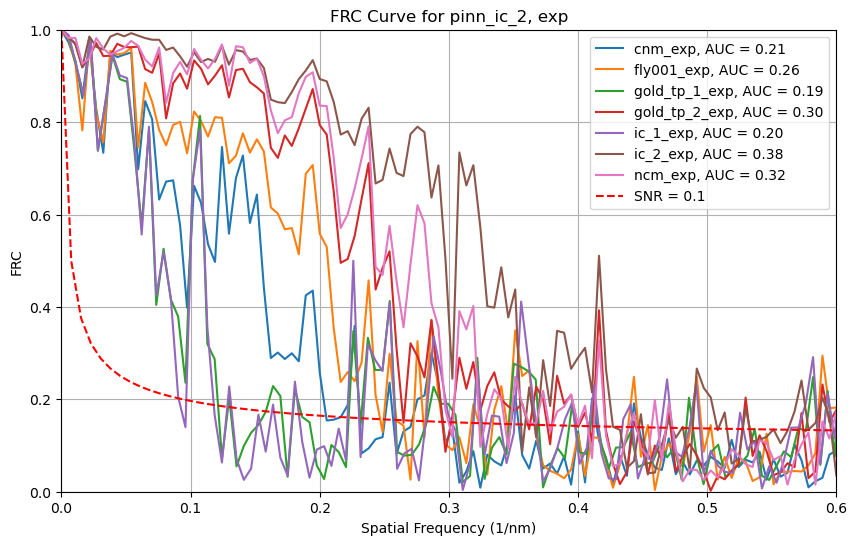

In [45]:
# Plotting
plot_frc_curves(frc_dict, 'pinn_ic_2', 'exp')

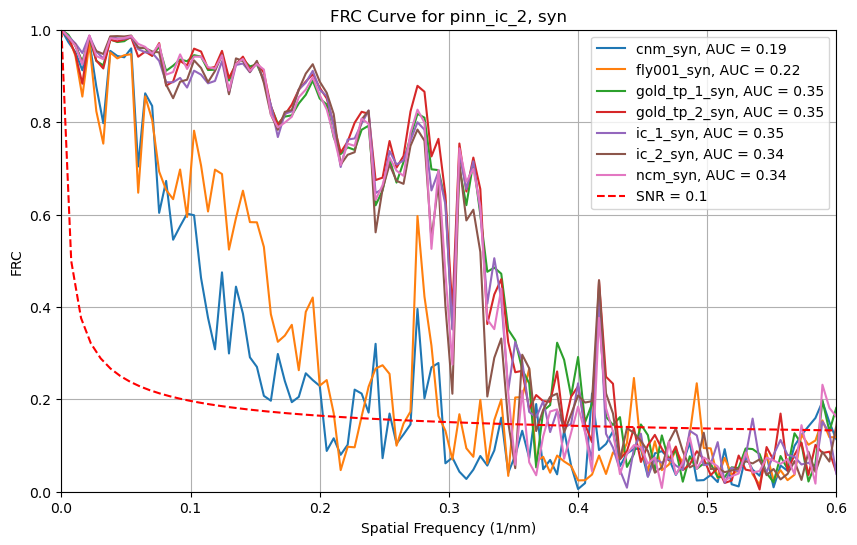

In [46]:
plot_frc_curves(frc_dict, 'pinn_ic_2', 'syn')

# Reconstruction plot

## Helper functions

In [19]:
## Quick and dirty reconstruction plotting

def generate_gt_and_recon(file, model_name, model_dict):
    
    model_id = model_dict[model_name]

    exp_name = file.split('/')[-1]

    # Check to see if need to replace data config
    if exp_name in ['pinn_gold_tp_1', 'pinn_ic_1']:
        data_config_replace = {"x_bounds": [0.07, 0.93],
                                "y_bounds": [0.07, 0.93]}
    else:
        data_config_replace = {}

    data_config_replace['n_subsample'] = 1  
    data_config_replace['scan_pattern'] = 'Rectangular'
    
    ptycho_dataset, data_config, model_config, training_config, inference_config = load_dataset(file, model_id,
                                                                                                  data_config_replace=data_config_replace)
        
    #Replacing inference config
    inference_config_replace = {'middle_trim': data_config.N//2,
                        'batch_size': 512,
                        'experiment_number': 0,
                        'pad_eval': True}

    update_existing_config(inference_config, inference_config_replace)
        
        
    print("Beginning reconstruction...")
    # Load model and reconstruct image
    result, recon_dataset = load_model_and_reconstruct(model_id, ptycho_dataset,
                                                    data_config, model_config,
                                                    training_config, inference_config)
    
    print("Recon complete. Beginning FRC calculation...")
    # Get target and prediction images
    gt, recon = get_target_and_prediction_images_and_window(result, recon_dataset,
                                                                window_size=window_size_dict[exp_name])
    
    return gt, recon

In [13]:
def plot_amp_and_phase(obj_amp, obj_phase, gt_amp, gt_phase):
    fig, axs = plt.subplots(2,2, figsize=(5,5))
    
    # obj_im[obj_im<-2] = 3
    #Object amp
    obj_plot = axs[0,0].imshow(obj_amp, cmap = 'gray')
    plt.colorbar(obj_plot, ax = axs[0,0])
    axs[0,0].set_title('Object Amplitude')
    axs[0,0].axis('off')

    #Object Phase
    phase_plot = axs[0,1].imshow(obj_phase, cmap = 'gray')#, vmin=-1, vmax=1)
    plt.colorbar(phase_plot, ax = axs[0,1])
    axs[0,1].set_title('Object Phase')
    axs[0,1].axis('off')

    #Ground turth amp
    gtamp_plot = axs[1,0].imshow(gt_amp, cmap = 'gray')
    plt.colorbar(gtamp_plot, ax = axs[1,0])
    axs[1,0].set_title('Ground Truth Amplitude')
    axs[1,0].axis('off')

    #ground truth phase
    gtphase_plot = axs[1,1].imshow(gt_phase, cmap = 'gray')
    plt.colorbar(gtphase_plot, ax = axs[1,1])
    axs[1,1].set_title('Ground Truth Phase')
    axs[1,1].axis('off')



In [14]:
def plot_single_amp_and_phase(obj_amp, obj_phase, title = 'Object'):
    """
    Plots a single amplitude and phase image.
    Args:
        obj_amp (np.ndarray): Object amplitude image.
        obj_phase (np.ndarray): Object phase image.
        title (str): Title for the plot.
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 5))
    
    # Object amp
    amp_plot = axs[0].imshow(obj_amp, cmap='gray')
    plt.colorbar(amp_plot, ax = axs[0], pad = 0.02)
    #Move colorbar directly next to plot
    axs[0].set_title('Amplitude')
    axs[0].axis('off')

    # Object Phase
    phase_plot = axs[1].imshow(obj_phase, cmap='gray')
    plt.colorbar(phase_plot, ax = axs[1], pad = 0.02)
    axs[1].set_title('Phase')
    axs[1].axis('off')

    plt.suptitle(title, fontsize = 14, fontweight='bold', x = 0.6)
    # plt.tight_layout()
    plt.show()

## Reconstruction and showing reconstruction results

In [22]:
gt, recon = generate_gt_and_recon('../../data/pinn_velo_fly001', 'pinn_velo_fly001_syn', model_dict)

Creating dataset...
Calculating dataset length with coordinate bounds...
For file ../../data/pinn_velo_fly001/fly001_64_train.npz, maximum x_range is (33.484195709228516, 198.51580810546875), yrange is (33.05133819580078, 198.9486541748047)
Creating memory mapped tensor dictionary...
Memory map length: 8125
Memory map creation time: 0.0008387565612792969
Populating memory map for dataset 0
Start - end = 8125
grouping
4_quadrant
Building KDTree for 10304 points...
Processing 8125 potential central points...
Finished quadrant neighbor processing. Found 8125 valid C=4 groups.
Non-diffraction memory map write time: 0.7226746082305908
Getting normalization coefficients...
Diffraction memory map write time: 0.2509500980377197
[PtychoDataset Rank 0] Initialization successful. Dataset length: 8125.
Beginning reconstruction...
Reconstructing image...
Batch 0 completed in 0.15165281295776367 seconds
Batch 1 completed in 0.15095043182373047 seconds
Batch 2 completed in 0.14959383010864258 seconds

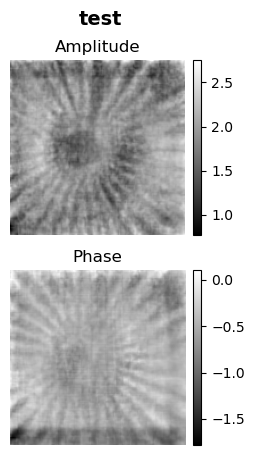

In [23]:
obj_amp, obj_phase = np.abs(recon), np.angle(recon)
# obj_phase[obj_phase > 0] = -np.pic
gt_amp, gt_phase = np.abs(gt), np.angle(gt)
plot_single_amp_and_phase(obj_amp, obj_phase, title = 'test')
# plot_single_amp_and_phase(gt_amp, gt_phase, title = 'Ground Truth')

# Scratch

In [14]:
file_dir = '../../data/pinn_fly001/'
#Use glob to get full npz file path based on file_dir
npz_files = glob.glob(os.path.join(file_dir, '*.npz'))
# Load the first npz file
dat = np.load(npz_files[0])
xcoords = dat['xcoords']
ycoords = dat['ycoords']
# Find min and max differences in xcoords and ycoords
x_diff = np.diff(xcoords)
y_diff = np.diff(ycoords)
print(f'Min x-coord_diff: {np.min(x_diff)}, Max x-coord_diff: {np.max(x_diff)}')
print(f'Min y-coord_diff: {np.min(y_diff)}, Max y-coord_diff: {np.max(y_diff)}')


Min x-coord_diff: -1.7900466918945312, Max x-coord_diff: 1.787933349609375
Min y-coord_diff: -0.7713661193847656, Max y-coord_diff: 0.1623077392578125


In [15]:
np.max(dat['diff3d'][0])

572

In [84]:
x_diff[:30]

array([1.50123215, 1.50123596, 1.50123215, 1.50123215, 1.50123596,
       1.50123215, 1.50123596, 1.50123215, 1.50123215, 1.50123596,
       1.50123215, 1.50123215, 1.50123596, 1.50123215, 1.50123215,
       1.50123596, 1.50123215, 1.50123215, 1.50123596, 1.50123215,
       1.50123215, 1.50123596, 1.50123596, 1.50122833, 1.50123596,
       1.50123596, 1.50122833, 1.50123596, 1.50123596, 1.50122833])

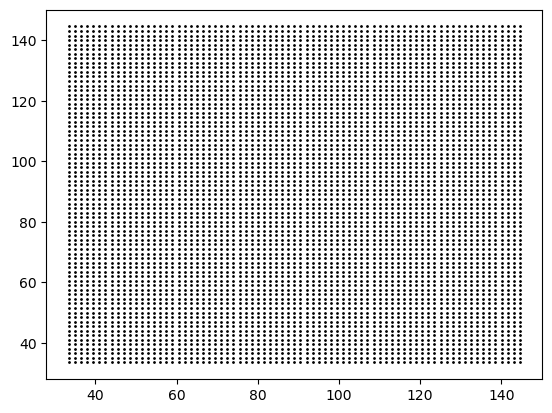

In [81]:
plt.scatter(xcoords, ycoords, s=1, c='black')